# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *

import psyplot.project as psy
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load files and edit datasets

LAM output analysis.

Simu irr et simu no-irr.

In [5]:
# lon_min=-10
# lon_max=4
# lat_min=34
# lat_max=46

In [6]:
nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/hourly_native'

## LMDZ

In [7]:
#noirr
no_irr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)

nat_lmdz_noirr0 = xr.open_dataset(no_irr_file)
nat_lmdz_noirr = nat_lmdz_noirr0.rename({'time_counter':'time'})
# nat_lmdz_noirr = nat_lmdz_noirr.assign_coords(time_decimal=nat_lmdz_noirr.time.dt.hour + nat_lmdz_noirr.time.dt.minute / 60)
# nat_lmdz_noirr.attrs['name'] = 'no_irr'
# nat_lmdz_noirr.attrs['plot_color']='red'
# nat_lmdz_noirr = nat_lmdz_noirr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

# nat_lmdz_noirr['sens']=-nat_lmdz_noirr['sens']
# nat_lmdz_noirr['flat']=-nat_lmdz_noirr['flat']

# nat_lmdz_noirr['ground_level'] = nat_lmdz_noirr['phis'] / 9.81
# nat_lmdz_noirr['ground_level'].attrs['units'] = 'm'

nat_lmdz_noirr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 ...
    lon                   (cell) float32 ...
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] ...
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] ...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/52)
    bounds_lon            (cell, nvertex) float32 ...
    bounds_lat            (cell, nvertex) float32 ...
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] ...
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] ...
    phis                  (time, cell) float32 ...
    ...                    ...
    vitu                  (time, presnivs, cell) float32 ...
    vitv                  (time, presnivs, cell) float32 ...
    vitw                  (time, presnivs, cell) float32 ...
    tke                   (time, presnivs, cell) float32 ...
    geoph                 (time, presnivs, cell) float32 ...
    ovap                  (time, presnivs, cell) float32 ...
Attributes:
    name:         histhf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:31:33 GMT
    uuid:         7a1ed6ba-ff11-44fc-895c-391e3a6fc32e

In [ ]:
#noirr
irr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)

nat_lmdz_irr0 = xr.open_dataset(irr_file)
nat_lmdz_irr = nat_lmdz_irr0.rename({'time_counter':'time'})

nat_lmdz_irr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 ...
    lon                   (cell) float32 ...
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] ...
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] ...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/52)
    bounds_lon            (cell, nvertex) float32 ...
    bounds_lat            (cell, nvertex) float32 ...
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] ...
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] ...
    phis                  (time, cell) float32 ...
    ...                    ...
    vitu                  (time, presnivs, cell) float32 ...
    vitv                  (time, presnivs, cell) float32 ...
    vitw                  (time, presnivs, cell) float32 ...
    tke                   (time, presnivs, cell) float32 ...
    geoph                 (time, presnivs, cell) float32 ...
    ovap                  (time, presnivs, cell) float32 ...
Attributes:
    name:         histhf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:31:33 GMT
    uuid:         7a1ed6ba-ff11-44fc-895c-391e3a6fc32e

## ORCHIDEE

In [8]:
filename = '{}/noirr/*HF_sechiba_out_2.nc'.format(hf_dir)

orc_noirr0 = xr.open_mfdataset(filename)
orc_noirr = orc_noirr0.rename({'time_counter':'time'})
orc_noirr = orc_noirr.assign_coords(time_decimal=orc_noirr.time.dt.hour + orc_noirr.time.dt.minute / 60)
orc_noirr.attrs['name'] = 'no_irr'
orc_noirr.attrs['plot_color']='red'
orc_noirr = orc_noirr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

orc_noirr

NameError: name 'hf_dir' is not defined

In [ ]:
filename = '{}/irr/*HF_sechiba_out_2.nc'.format(hf_dir)

orc_irr0 = xr.open_mfdataset(filename)
orc_irr = orc_irr0.rename({'time_counter':'time'})
orc_irr = orc_irr.assign_coords(time_decimal=orc_irr.time.dt.hour + orc_irr.time.dt.minute / 60)
orc_irr.attrs['name'] = 'irr'
orc_irr.attrs['plot_color']='#0C5DA5'
orc_irr = orc_irr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

orc_irr

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, veget: 15, time: 248,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * veget                 (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T01:30:00 ... 2021-...
    time_decimal          (time) float64 1.5 4.5 7.5 10.5 ... 16.5 19.5 22.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/24)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    Areas                 (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    Contfrac              (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    ...                    ...
    tair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    qair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    humrel                (time, veget, lat, lon) float32 dask.array<chunksize=(248, 15, 35, 49), meta=np.ndarray>
    root_deficit          (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    netirrig              (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    irrigation            (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 05:16:33 GMT
    uuid:         9f3b5cbf-cc6c-4c1c-ab94-98404e8b374c
    plot_color:   #0C5DA5

## Masking

### IP continental subdomain

In [ ]:
# Define masks
 
con_mask_2D_ORC= orc_noirr.mean(dim='time')['Contfrac']>0.95
con_mask_2D_ORC.attrs['name']='Continental mask (95%)'

ip_polygon_mask_2D=polygon_to_mask(orc_noirr.mean(dim="time"), iberian_peninsula)
ip_polygon_mask_2D.attrs['name']='Iberian Peninsula polygon mask'

#combine two masks
ip_mask = con_mask_2D_ORC * ip_polygon_mask_2D
ip_mask.attrs['name']='IPmask'

In [ ]:
#ORC
ip_orc_noirr = apply_2Dmask_to_dataset(orc_noirr, ip_mask, dsname='no_irr')
ip_orc_irr = apply_2Dmask_to_dataset(orc_irr, ip_mask, dsname='irr')

In [ ]:
#LMDZ
ip_lmdz_noirr = apply_2Dmask_to_dataset(lmdz_noirr, ip_mask, dsname='no_irr')
ip_lmdz_irr = apply_2Dmask_to_dataset(lmdz_irr, ip_mask, dsname='irr')

NameError: name 'lmdz_noirr' is not defined

## high_irr vs low_irr

In [ ]:
#on grid cell
#highirr
Cendrosa_lon=0.6
Cendrosa_lat=41.7
#lowirr
ElsPlans_lon=1.1
ElsPlans_lat=41.5

In [ ]:
cen_lmdz_noirr = lmdz_noirr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_lmdz_noirr.attrs['name']='La Cendrosa no_irr'
cen_lmdz_irr = lmdz_irr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_lmdz_irr.attrs['name']='La Cendrosa irr'
cen_orc_noirr = orc_noirr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_orc_noirr.attrs['name']='La Cendrosa no_irr'
cen_orc_irr = orc_irr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_orc_irr.attrs['name']='La Cendrosa irr'

In [ ]:
els_lmdz_noirr = lmdz_noirr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_lmdz_noirr.attrs['name']='Els Plans no_irr'
els_lmdz_irr = lmdz_irr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_lmdz_irr.attrs['name']='Els Plans irr'
els_orc_noirr = orc_noirr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_orc_noirr.attrs['name']='Els Plans no_irr'
els_orc_irr = orc_irr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_orc_irr.attrs['name']='Els Plans irr'

In [ ]:
cendrosa_gl= cen_lmdz_noirr['ground_level'].mean(dim='time').values.item()
elsplans_gl= els_lmdz_noirr['ground_level'].mean(dim='time').values.item()
cendrosa_gl,  elsplans_gl

(315.8647155761719, 474.1612548828125)

# Maps

psyplot.project.Project([    arr1: 1-dim DataArray of t2m, with (cell)=(9241,), time_centered=2021-07-01T00:30:00, time_counter=2021-07-01T00:30:00, time_instant=2021-07-01T01:00:00])

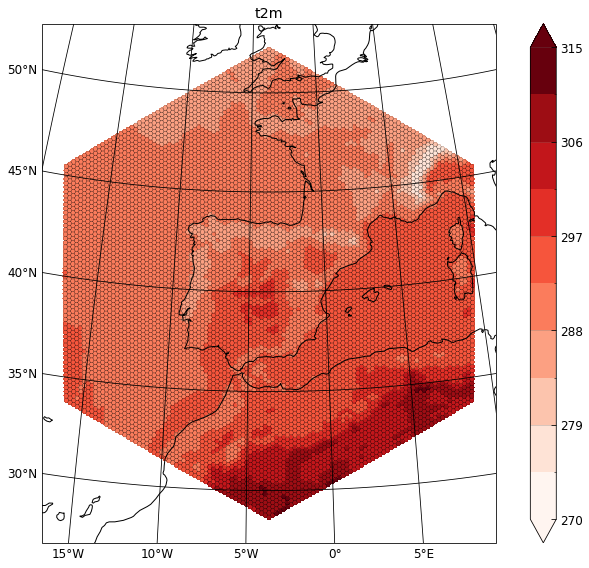

In [12]:
file=no_irr_file
var='t2m'
vmin=0.0
vmax=30
# vmin, vmax=None,None
pas=(vmax-vmin) / 10

psy.plot.mapplot(
    file, 
    name=var,
    datagrid=dict(color='k', linewidth=0.2),
    cbar='r',
    tight=True,
    lsm='50m',
    cmap=reds,
    extend='both',
    projection='ortho',
    #add title
    title=var,
    # bounds=np.arange(vmin, vmax + pas, pas)
)

In [20]:
def calculate_cell_centers_and_vertices(ds):
    """
    Calculate cell centers and vertices from the available data in the dataset.

    Parameters:
    - ds: xarray.Dataset containing the hexagonal grid data.

    Returns:
    - cell_centers: Array of cell center coordinates.
    - vertices: Array of vertex coordinates for each cell.
    """
    # Placeholder for calculating cell centers and vertices
    # You need to replace this with the actual calculation based on your data
    num_cells = ds.dims['cell']
    num_vertices = ds.dims['nvertex']

    # Example: Generate dummy cell centers and vertices
    cell_centers = np.random.rand(num_cells, 2)  # Replace with actual calculation
    vertices = np.random.rand(num_cells, num_vertices, 2)  # Replace with actual calculation

    return cell_centers, vertices

In [21]:
def plot_hexagonal_grid(ds, variable_name, time_index=0, ax=None):
    """
    Plot data from a hexagonal grid NetCDF file using xarray.

    Parameters:
    - ds: xarray.Dataset containing the hexagonal grid data.
    - variable_name: Name of the variable to plot.
    - time_index: Index of the time step to plot.
    - ax: Matplotlib axis to plot on. If None, a new figure and axis will be created.

    Returns:
    - ax: Matplotlib axis with the plot.
    """
    # Access the variable data
    data = ds[variable_name].isel(time=time_index)

    # Calculate cell centers and vertices
    cell_centers, vertices = calculate_cell_centers_and_vertices(ds)

    # Create a new figure and axis if none is provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot each hexagonal cell
    for cell_index in range(len(cell_centers)):
        cell_data = data.isel(cell=cell_index).values
        cell_vertices = vertices[cell_index]

        # Plot the hexagon
        hexagon = plt.Polygon(cell_vertices, edgecolor='k', facecolor=plt.cm.viridis(cell_data))
        ax.add_patch(hexagon)

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=data.min(), vmax=data.max()))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=variable_name)

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{variable_name} at time index {time_index}')

    return ax

<Axes: title={'center': 't2m at time index 0'}, xlabel='Longitude', ylabel='Latitude'>

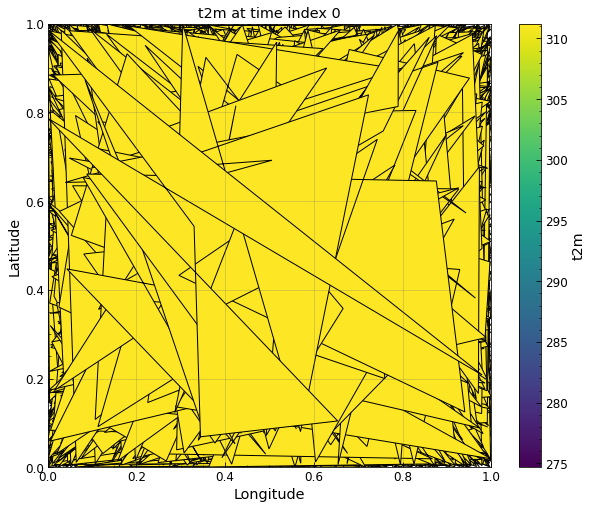

In [22]:
ds=nat_lmdz_irr
var='t2m'
plot_hexagonal_grid(ds, var, time_index=0, ax=None)

# Time series and diurnal cycle

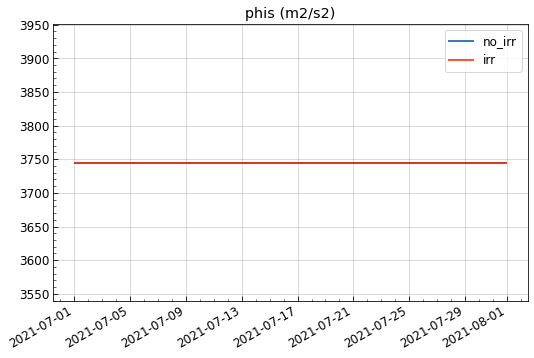

In [ ]:
var='phis'

ds1=lmdz_noirr
ds2=lmdz_irr
ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds1]

title=None
time_series_ave(ds_list, var, title='{} ({})'.format(var, ds1[var].attrs['units']))


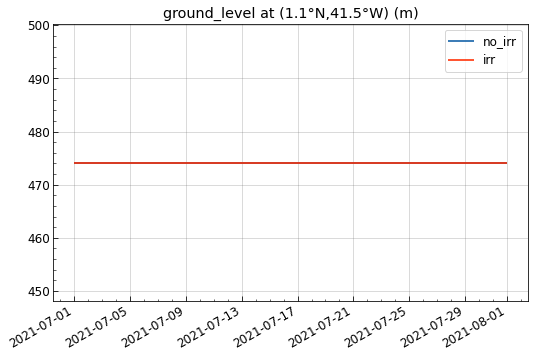

In [ ]:
#en un point precis
lon=Cendrosa_lon
lat=Cendrosa_lat

lon=ElsPlans_lon
lat=ElsPlans_lat
# lon=-2
# lat=41
var='ground_level'
ds1=lmdz_noirr
ds2=lmdz_irr
# ds1=orc_noirr
# ds2=orc_irr
ds_list=[ds1, ds2]
time_series_lonlat(ds_list, var, lon, lat)

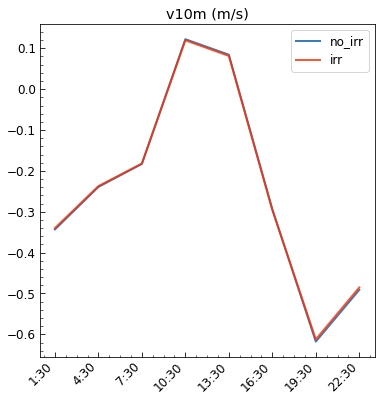

In [ ]:
var='v10m'

ds1=ip_lmdz_noirr
ds2=ip_lmdz_irr
# ds1=ip_orc_noirr
# ds2=ip_orc_irr
ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds2]

title=None
diurnal_cycle_ave(ds_list, var, title='{} ({})'.format(var, ds1[var].attrs['units']))

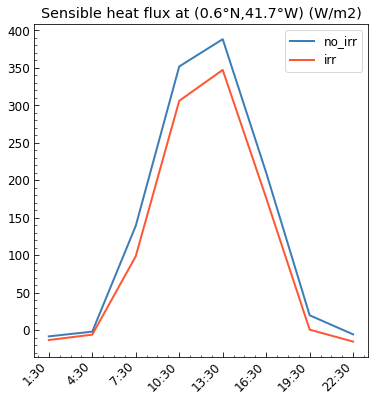

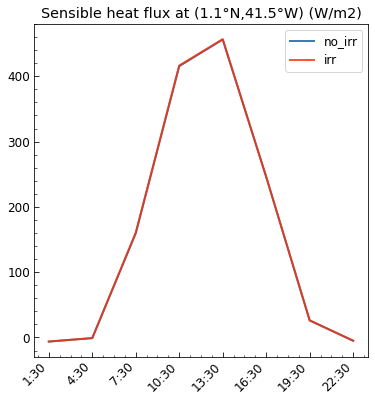

In [ ]:
var='sens'

ds1=ip_lmdz_noirr
ds2=ip_lmdz_irr
# ds1=ip_orc_noirr
# ds2=ip_orc_irr

ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds2]

title=None

lon=Cendrosa_lon
lat=Cendrosa_lat

diurnal_cycle_lonlat(ds_list, var, lon=lon, lat=lat)

lon=ElsPlans_lon
lat=ElsPlans_lat

diurnal_cycle_lonlat(ds_list, var, lon=lon, lat=lat)

# Vertical profiles

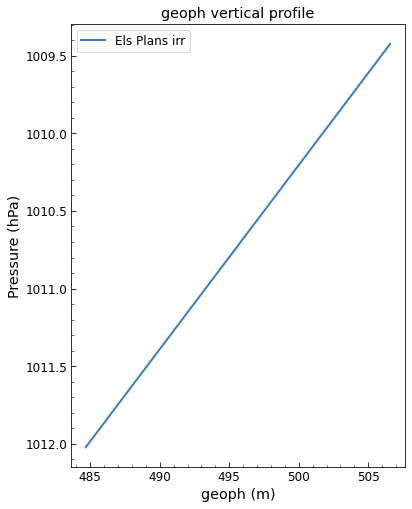

In [ ]:
var='geoph'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

# ds_list=[ds1, ds2, ds3, ds4]
ds_list=[ds1]

preslevelmax=2

title=None

profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)

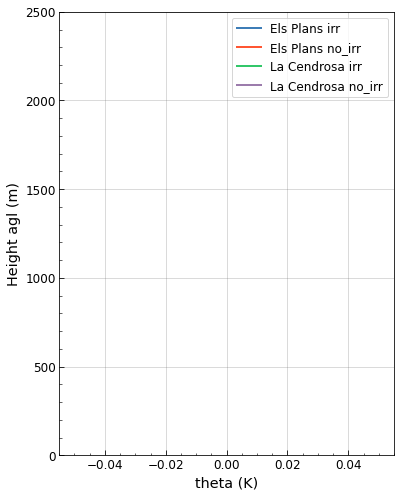

In [ ]:
var='theta'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

day='2017-07-10'

ds11=filter_xarray_by_day(ds1, day)
ds21=filter_xarray_by_day(ds2, day)
ds31=filter_xarray_by_day(ds3, day)
ds41=filter_xarray_by_day(ds4, day)

ds_list=[ds1, ds2, ds3, ds4]
ds_list=[ds11, ds21, ds31, ds41]

altmax=2500

title=None

# profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)
profile_altitude_local_mean(ds_list, var, title=title, altmax=altmax,
                       nbins=None,
                       substract_gl=False,
                       )

In [ ]:
ds11

<xarray.Dataset>
Dimensions:               (presnivs: 79, time: 0, axis_nbounds: 2)
Coordinates:
    lat                   float32 41.46
    lon                   float32 1.193
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(0,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 
    time_instant          (time) datetime64[ns] dask.array<chunksize=(0,), meta=np.ndarray>
    time_decimal          (time) float64 
Dimensions without coordinates: axis_nbounds
Data variables: (12/51)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    phis                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    aire                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    contfracATM           (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                    ...
    vitv                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    vitw                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    tke                   (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    geoph                 (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    ovap                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    ground_level          (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
Attributes:
    name:         Els Plans irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 05:16:38 GMT
    uuid:         f5df34c4-d004-4324-87e7-258a451aed33
    plot_color:   #0C5DA5

In [ ]:
def profile_altitude_multipletimes(ds_list, var, times, altmin=0, altmax=2000):
    n_ax = len(times)
    fig, axs = plt.subplots(1, n_ax, figsize=(5*n_ax, 6))
    # Flatten axs only if it's an array (i.e., more than one subplot)
    axes = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    for i, time in enumerate(times):
        hour=times_correspondance[time]
        title = f"{var} at {hour}"
        
        # Filter datasets by the specified time and plot
        ds_list_tmp = [ds.where(ds['time_decimal']==time) for ds in ds_list]
        profile_altitude_local_mean(ds_list_tmp,
                                    var,
                                    ax=axes[i],
                                    title=title,
                                    altmin=altmin,
                                    altmax=altmax
        )

NotImplementedError: 'item' is not yet a valid method on dask arrays

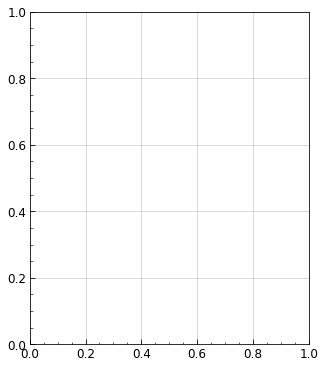

In [ ]:
var='theta'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

ds_list=[ds1, ds2, ds3, ds4]

altmin=-0
altmax=2000

times=[1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5]
times=[13.5, 16.5]
times=[13.5]

profile_altitude_multipletimes(ds_list, var, times, altmin=altmin, altmax=altmax)